# Homework Assignment #2

*due Tuesday, February 15, 2019 by 11:59pm*

This homework is worth **10 points** [100%], there are no bonus points questions, however, up to 1 bonus point may be given for **clearly written code** (provided that the code is correct).

### n.b.
All deliverables are required to be typed and all graphs and statistical output generated in Jupyter Notebook using Python and associated packages. Deliverables with *any* handwritten elements will not be accepted and will receive a grade of zero. 

Similarly to `hw1` copy the whole directory `hw2` to your own private repository (**use the same one as for `hw1`**).

In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sb

from scipy.linalg import eigh
from scipy.stats import norm
from sklearn.metrics import r2_score
from sklearn import linear_model

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Linear Regression - the closed form solution [total of 15%]

***DO NOT USE ANY REGRESSION FUNCTIONS OR REGRESSION PACKAGES FOR THIS PROBLEM***

### Data for Part 1:
Suggested steps:
* Read the [housing data](https://s3-us-west-1.amazonaws.com/usfca-cs686-ml/hw1/housing.csv) used in `hw1`
* Use the column "`GrLivArea`" as your independent variable and "`SalePrice`" as your dependent variable. (You can safely disregard the rest of the dataset)

In [33]:
# Read the data here (not graded)
data_path = os.path.join(os.path.dirname(os.getcwd()), "hw1", "data", "housing.csv")
df = pd.read_csv(data_path)[["GrLivArea", "SalePrice"]]

#### Find estimates for $\beta_0$ and $\beta_1$

We know that the formula for $\beta_0$ and $\beta_1$ are:
$$\beta_0 = \bar{Y} - \beta_1\bar{X}$$
<br>
$$\beta_1 = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{\sum_{i=1}^{n}(X_i - \bar{X})^2} = \frac{s_{xy}}{s_x^2}$$

In [34]:
X_minus_mean = (df - df.mean())["GrLivArea"]
Y_minus_mean = (df - df.mean())["SalePrice"]
covariance_xy = np.sum(X_minus_mean * Y_minus_mean)
variance_x = np.sum(np.square((df - df.mean())["GrLivArea"]))
beta1 = covariance_xy / variance_x
beta0 = df.mean()["SalePrice"] - beta1 * df.mean()["GrLivArea"]
beta0, beta1

(18569.02585648728, 107.13035896582517)

#### Find $R^2$

$$R^2 = \frac{SSR}{SSTO} = 1 - \frac{SSE}{SSTO}$$
<br>
<center>where </center>
$$SSTO \equiv \sum_{i=1}^{n}(Y_i - \bar{Y})^2$$
$$SSE \equiv \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2$$
$$SSR \equiv \sum_{i=1}^{n}(\hat{Y_i} - \bar{Y})^2$$

In [35]:
df["PredictionPrice"] = beta0 + df["GrLivArea"] * beta1

In [36]:
SSTO = np.sum(np.square(df["SalePrice"] - df.mean()["SalePrice"]))
SSE = np.sum(np.square(df["SalePrice"] - df["PredictionPrice"]))
SSR = np.sum(np.square(df["PredictionPrice"] - df.mean()["SalePrice"]))

In [37]:
(SSR/SSTO, 1 - SSE/SSTO)

(0.5021486502718039, 0.5021486502718042)

$$R^2 = 0.5021$$

## Part 2: Linear Regression - the iterative solution [total of 35%]

***YOU ARE ASKED TO CODE THE FOLLOWING EXERCISE FROM SCRATCH. DO NOT USE ANY PACKAGES FOR AUTOMATIC DIFFERENTIATION FOR THIS PROBLEM.***

### <span style="color: #DA122C;">**YOUR SOLUTION MUST WORK FOR ANY GIVEN NUMBER OF INDEPENDENT VARIABLES**</span>

HINT: To make your implementation stand out, try implementing this question following a functional programming paradigm (i.e. define functions)

In [38]:
## YOU WILL NEED THESE PARAMETERS ##
# DO NOT CHANGE ANYTHING IN THIS CELL
init_eta = 1e-4 # eta, gamma, learning rate or whatever you want to call it ¯\_(ツ)_/¯
num_iters = 100 # number of iterations
n = 1000

In [39]:
# DO NOT CHANGE ANYTHING IN THIS CELL
np.random.seed(42)
r = np.eye(int(np.sqrt(n)/3)-1)
r += np.random.normal(0, 0.1, size=(r.shape[0],)*2)
lams, A = eigh(r)
c = np.dot(A, np.diag(np.sqrt(lams)))
X = np.dot(c, norm.rvs(size=(r.shape[0], n))).transpose()
Y = np.random.randn(r.shape[0]+1).dot(np.concatenate((X, np.ones((n,1))), axis=1).transpose()) + np.random.normal(0, 0.5, n)
del r, lams, A, c


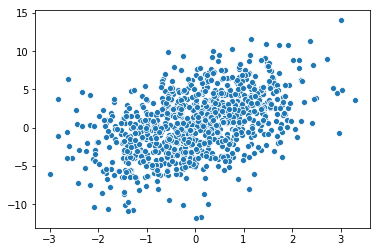

In [40]:
sb.scatterplot(X[:,0], Y)

Using MSE for the loss function, where
$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y} - Y_i)^2$$
#### Gradient Descent for Linear regression
$$Cost function = J(\Theta_0, \Theta_1) = \frac{MSE}{2} = \frac{1}{2m}\sum_{i=1}^{m}(\hat{Y} - Y_i)^2$$
$$J(\Theta_0, \Theta_1) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\Theta}(X_i) - Y_i)^2$$
$$h_\Theta(X_i) = \Theta_0 + \Theta_1 X_i$$



$$\Theta_j := \Theta_j - \eta \frac{\partial}{\partial \Theta_j} J(\Theta_0, \Theta_1)$$
$$\frac{\partial J_\Theta}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m}(h_\Theta (X_i) - Y_i) \frac{\partial}{\partial \Theta_j} ((\Theta_0 + \Theta_1 X_i) + Y_i)$$

$$\Theta_0 := \Theta_0 - \eta \frac{1}{m} \sum_{i=1}^{m}(h_\Theta (X_i) - Y_i)$$
$$\Theta_1 := \Theta_1 - \eta \frac{1}{m} \sum_{i=1}^{m}(h_\Theta (X_i) - Y_i)X_i$$

In [55]:
# Start your solution here with data X and labels Y
def single_linear_regression(X, Y, init_eta, num_iters, n):
    theta0 = 0
    theta1 = 0
    
    for i in range(num_iters):
        if (i % 10 == 0):
            print(theta0, theta1)
        predictions = theta0 + theta1 * X
        theta0 = theta0 - init_eta / X.shape[0] * np.sum(predictions - Y)
        theta1 = theta1 - init_eta / X.shape[0] * np.sum((predictions - Y) * X)
        
    return theta0, theta1
    
single_linear_regression(X[:,0], Y, init_eta, num_iters, n)

0 0
0.0006167370630693589 0.0018405670301014556
0.0012328540002716686 0.003679162244512889
0.0018483514353815117 0.005515787755576983
0.002463229991545771 0.00735044567337362
0.0030774902912842584 0.0091831381057223
0.003691132956490347 0.011013867158184566
0.0043041586084316035 0.012842634934066417
0.004916567867750416 0.014669443534420736
0.005528361354464624 0.016494295058049686


(0.006139539687968149, 0.018317191601507132)

In [42]:
def graph_gradient_descent(X, Y, theta0, theta1, num_iters):
    plt.plot(X, Y, '.')
    plt.plot(X, theta0 + theta1 * X, '-')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.text(2.5, 10.5, "Num iter: %d" % num_iters)
    plt.show()

0 0
0.05898218489973528 0.17551290924343058
0.11229275278696234 0.33309571842831526
0.16047726697527462 0.47458007180689127
0.2040287926256275 0.601610508675522
0.24339295047824913 0.7156635758141204
0.27897248388746865 0.8180649876798527
0.3111313860508434 0.9100050337624737
0.3401986298041085 0.9925524121411837
0.3664715382694931 1.0666666499957167


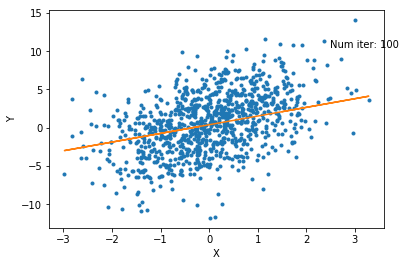

In [43]:
regress_values = single_linear_regression(X[:,0], Y, 0.01, num_iters, n)

graph_gradient_descent(X[:,0], Y, regress_values[0], regress_values[1], num_iters)

Multiple Linear Regression

Using MSE for the loss function, where
$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y} - Y_i)^2$$
#### Gradient Descent for Linear regression
$$Cost function = J(\Theta_0, \Theta_1) = \frac{MSE}{2} = \frac{1}{2m}\sum_{i=1}^{m}(\hat{Y} - Y_i)^2$$
$$J(\Theta_0, \Theta_1) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\Theta}(X_i) - Y_i)^2$$
$$h_\Theta(X_i) = \Theta_0 + \Theta_1 X_1 + \Theta_2 X_2 + \ldots + \Theta_{n-1} X_{n-1}$$

In [52]:
# Start your solution here with data X and labels Y
def multiple_linear_regression(X, Y, init_eta, num_iters, n):
    thetas = np.zeros(X.shape[1])
    
    for i in range(num_iters):
        if (i % 10 == 0):
            print(theta0, theta1)
        predictions = theta0 + theta1 * X
        theta0 = theta0 - init_eta / X.shape[0] * np.sum(predictions - Y)
        theta1 = theta1 - init_eta / X.shape[0] * np.sum((predictions - Y) * X)
    return thetas.T


In [56]:
h = np.ones(X.shape[1] + 1)
X = 

In [59]:
h.shape

(10,)

In [54]:
print(multiple_linear_regression(X, Y, init_eta, num_iters, n))

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Part 3: Theory [total of 50%]

### Question 1

In the SLR model, the probability distribution of $Y$ (i.e., $Y_i$) has the same mean and variance for all levels of $X$ (i.e., $X_i$). True or False? Explain.

We know that the SLR model of the bivariate variables, X, Y is: 
$$Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$

To examine the mean of on the distribution of Y, we take the expectation of both sides:
\begin{align}
E[Y_i] & = E[\beta_0 + \beta_1 X_i + \epsilon_i \\
E[Y_i] & = E[\beta_0] + E[\beta_1 X_i] + E[\epsilon_i] \\
E[Y_i] & = \beta_0 + \beta_i E[X_i] + E[\epsilon_i] \\
E[Y_i] & = \beta_0 + \beta_i X_i
\end{align}

Since the expected value of Y is a function of X, it is not constant. **Therfore the mean of Y varies for all levels of X.**

Similarly, if we take the variance on SLR,

\begin{align}
V[Y_i] & = V[\beta_0 + \beta_1 X_i + \epsilon_i] \\
V[Y_i] & = V[\beta_0] + V[\beta_1 X_i] + V[\epsilon_i] \\
V[Y_i] & = v[\epsilon_i] \\
V[Y_i] & = \epsilon_i
\end{align}

We can see that the variance of Y is a constant value, so variance is **same across all levels of X.**

### Question 2

The number of points above the fitted regression line is always equal to the number of points below it. True or False? Explain.

**False** <br>
False because the fitted line tries to minimize the Mean Squared Error (MSE) across all points. Say we are fitting for 3 points, if one point is above and **far** from the line, two points below the line will be placed relatively closer to the line.

False. If there are equal number of points above and below, the line will go through the median of the error. However, SLR tries to find the MSE; the median is not always the same as the mean in a distribution.

### Question 3

In a SLR model, what does $\beta_1$ measure?  

Slope of the regression. In other words, the mean increase in the dependent variable, Y, per unit increase in the independent variable, X.

### Question 4

In the context of an SLR model, prove the following:

- $E[Y_i] = \beta_0 + \beta_1 X_i$ 
- $V(Y_i) = \sigma^2 \hspace{5pt} \forall \hspace{5pt} i$ 

We know that the SLR model of the bivariate variables, X, Y is: 
$$Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$

Applying the expectation on both sides:
\begin{align}
E[Y_i] & = E[\beta_0 + \beta_1 X_i + \epsilon_i] \\
E[Y_i] & = E[\beta_0] + E[\beta_1 X_i] + E[\epsilon_i] \\
E[Y_i] & = \beta_0 + \beta_i E[X_i] + E[\epsilon_i] \\
E[Y_i] & = \beta_0 + \beta_i E[X_i] \\
E[Y_i] & = \beta_0 + \beta_i X_i
\end{align}

We apply the variation on both sides of SLR: <br>
\begin{align}
V[Y_i] & = V[\beta_0 + \beta_1 X_i + \epsilon_i] \\
V[Y_i] & = V[\beta_0] + V[\beta_1 X_i] + V[\epsilon_i] \\
V[Y_i] & = V[\epsilon_i] \\
V[Y_i] & = \epsilon_i
\end{align}

### Question 5

For the SLR model, $Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$, how many random variables are there. Explain.

In SLR, we assume that values of $X_i$ is fixed and known. We also know that the error term, $\epsilon_i$ is random by nature. Since $Y_i$ is dependent on the error term, $Y_i$ is also a random variable. Therefore, there are 2 random variables.

### Question 6

Write out the normal error regression model and its assumptions (in English and math).

$$Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$
The normal error regression model has several assumptions, <br>
1. $E[\epsilon_i|X_i] = 0$ ; 
2. $V[\epsilon_i|X_i] = \sigma^2$, $\forall$ i ; Constant error variance
3. $\sigma[\epsilon_i, \epsilon_j | X_i] = 0$, $\forall$ i, j and i $\neq$ j ; 
4. $\sigma[X_i, \epsilon_i] = 0$, $\forall$ i ; 

$$Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$
The normal error regression model has several assumptions, <br>
1. $E[\epsilon_i|X_i] = 0$ ; Estimated residuals are unrelated to the regressors.
2. $V[\epsilon_i|X_i] = \sigma^2$, $\forall$ i ; Variability of the error is constant throughout all X
3. $\sigma[\epsilon_i, \epsilon_j | X_i] = 0$, $\forall$ i, j and i $\neq$ j ; There is no correlation between the error terms, meaning they are random
4. $\sigma[X_i, \epsilon_i] = 0$, $\forall$ i ; Meaning there is no correlation between the X and the error term

### Question 7

What does a negative value of $\beta_1$ indicate about the relation between $X$ and $Y$?

$$ b_1 = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sum (X_i - \bar{X})^2}$$

The negative value of $\beta_1$ indicates that there is a negative relation between X and Y; if X increases, Y decreases and vice versa.

### Question 8

Are hypotheses tested concerning the actual values of the coefficients, e.g., $\beta_1$, or their estimated values, e.g., $b_1$? Why?

The true values of the coefficients. We want to check if the regressed values $b_0$ and $b_1$ are statistically significantly different from the true values, $\beta_0$ and $\beta_1$.

### Question 9

You compute a coefficient of determination for a regression model an obtain an $R^2=0.832$. What does the strength of the coefficient of determination say about the causal relationship between the explanatory and response variables?

$R^2$ cannot explain the causal relationship between the explanatory and response variables. $R^2$ simply measures the goodness of the fitted line, although in of it itself is insufficient to fully determine how good the fitted line is.

### Question 10

You compute a coefficient of determination for a regression model, regressing crime rate per capita ($Y$) on the size of municipal police force ($X$), obtaining an $R^2 = 0.6533$. What can you say about the relationship between $Y$ and $X$?

$R^2 = 0.6533$ epxlains that the model explains 65% of the data's variance on the mean

### Question 11

From the discussion of SLR so far, how do you believe outliers will effect the regression line? 

Outliers will likely greatly affect the slope $b_1$ of the regression line, and also the $b_0$ since $b_1$.

$$ b_0 = \frac{1}{n} \Big( \sum Y_i - b_1 \sum X_i \Big) $$
$$ b_1 = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sum (X_i - \bar{X})^2}$$

Outliers are by definition, points that are diverging in a big way from the overall pattern, either by extreme X, Y values or simply just distant.

If the X and/or Y values are extreme/outlying, we can see that the value of $b_1$ may fluctuate a lot; the numerator is the sum of the multiplication of deviation of $X$ from $\hat{X}$ and deviation of $Y$ from $\hat{Y}$, so the whole sum may increase/decrease. Similarly, the denominator is the sum of squares of deviation of $Y$ which also fluctuates with extreme/outlying Y.
<br>
Also by definition, $b_0$ is a function of $b_1$, meaning fluctuations in $b_1$ also affects $b_0$

### Question 12

Write out the hypothesis test which tests for the statistical significance of $\beta_1$ for an SLR model. Be sure to include the null an alternate hypothesis, the critical value including degrees of freedom (two-tailed test) for $\alpha = 0.05$ and an interpretation of both possible results. 

\begin{align}
H_0: \beta_1 & = 0 \\
H_1: \beta_1 & \neq{} 0 \\
\alpha &= 0.05 \\
\end{align}

Since this is a two-tailed test, we want to find confidnece value for $\frac{\alpha}{2} = \frac{0.05}{2} = 0.025$
<br>
The degrees of freedom is 2, since there is one independent and one dependent variable.

If $\sigma$ is not known, we use the t-static, where the critical value is:
$$t_{(n-1, \frac{n}{2})}$$
if $\sigma$ is known, the critical value is:
$$z_{\frac{\alpha}{2}}$$
If $P(X <= |z|) < = 0.025$, $\beta_1$ is statistically significantly different and we can reject the null hypothesis.


### Question 13

Using ```modified_SENIC_data_01.csv```
1. Regress Infection Risk ($Y$) on Length of Stay ($X$). Report the $R^2$, $b_0$ and $b_1$  values.
2. Multiply the observations, both $X$ and $Y$, by 192; we will refer to these as $X_{(2)}$ and $Y_{(2)}$. Regress $Y_{(2)}$ on $X_{(2)}$. Report the $R^2$, $b_0$ and $b_1$  values.
3. Multiply only $Y$ by 47; we will refer to this as $Y_{(3)}$. Regress $Y_{(3)}$ on $X$. Report the $R^2$, $b_0$ and $b_1$  values.
4. Multiply only $X$ by 12; we will refer to this as $X_{(3)}$. Regress $Y$ on $X_{(3)}$. Report the $R^2$, $b_0$ and $b_1$  values.


**Succinctly** explain what you have gleaned from this exercise. Include a summarized tabular representation of the regression output and the associated $R^2$, $b_0$ and $b_1$ values.

In [13]:
path = os.path.join(os.path.dirname(os.getcwd()), "hw2", "data", "modified_SENIC_data_01.csv")
df = pd.read_csv(path)

In [14]:
df.head(5)

,lengthOfStay,age,infectionRisk
0,7.13,55.7,4.1
1,8.82,58.2,1.6
2,8.34,56.9,2.7
3,8.95,53.7,5.6
4,11.20,56.5,5.7


In [15]:
X = df[["lengthOfStay"]]
y = df[["infectionRisk"]]
print(X.shape, Y.shape)

(113, 1) (1000,)


In [16]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
y_pred = regr.predict(X)

In [18]:
print("r2 score: %.3f, b0: %.3f, b1: %.3f" % (r2_score(y, y_pred), regr.intercept_, regr.coef_))

r2 score: 0.285, b0: 0.744, b1: 0.374


In [19]:
## stats model implementation
ols_X = df["lengthOfStay"] 
ols_y = df["infectionRisk"] 
ols_X = sm.add_constant(X)

model = sm.OLS(ols_y, ols_X).fit()
predictions = model.predict(ols_X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          infectionRisk   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     44.15
Date:                Fri, 15 Feb 2019   Prob (F-statistic):           1.18e-09
Time:                        02:45:06   Log-Likelihood:                -174.07
No. Observations:                 113   AIC:                             352.1
Df Residuals:                     111   BIC:                             357.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7443      0.554      1.344      0.182      -0.353       1.842
lengthOfStay     0.3742      0.056      6.645      0.000       0.263       0.486
==============================================================================
Omnibus:                        1.189   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                1.228
Skew:                          -0.237   Prob(JB):                        0.541
Kurtosis:                       2.811   Cond. No.                         51.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
X2 = X * 192
y2 = y * 192
regr2 = linear_model.LinearRegression()
regr2.fit(X2, y2)
y_pred2 = regr.predict(X2)
print("r2 score: %.3f, b0: %.3f, b1: %.3f" % (r2_score(y2, y_pred2), regr2.intercept_, regr2.coef_))

r2 score: -0.023, b0: 142.906, b1: 0.374


In [21]:
y3 = y * 47
regr3 = linear_model.LinearRegression()
regr3.fit(X, y3)
y_pred3 = regr.predict(X)
print("r2 score: %.3f, b0: %.3f, b1: %.3f" % (r2_score(y3, y_pred3), regr3.intercept_, regr3.coef_))

r2 score: -10.182, b0: 34.982, b1: 17.588


In [22]:
X3 = X * 17
regr4 = linear_model.LinearRegression()
regr4.fit(X3, y)
y_pred4 = regr.predict(X3)
print("r2 score: %.3f, b0: %.3f, b1: %.3f" % (r2_score(y, y_pred4), regr4.intercept_, regr4.coef_))

r2 score: -1945.195, b0: 0.744, b1: 0.022


### Question 14

Using the ```fourDataSets.csv```, regress $Y$ on $X$ for $i=1,2,3,4$, i.e., generate four separate SLR models. **For each** of the four data sets, run and report summary statistics, generate a scatter plot and run a SLR model, reporting the regression function $R^2$, $R_a^2$, and the significance of $b_1$ ($p$-value). Intelligently discuss what you observe about each data set and the data sets as a whole.

In [3]:
path = os.path.join(os.path.dirname(os.getcwd()), "hw2", "data", "fourDataSets.csv")
df = pd.read_csv(path)

In [4]:
df.head()

,dataSet,x,y
0,1,10,8.04
1,1,8,6.95
2,1,13,7.58
3,1,9,8.81
4,1,11,8.33


In [5]:
df1 = df[df["dataSet"] == 1]
df2 = df[df["dataSet"] == 2]
df3 = df[df["dataSet"] == 3]
df4 = df[df["dataSet"] == 4]

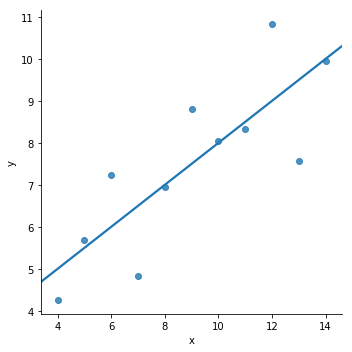

In [17]:
ols_X1 = df1.x
ols_y1 = df1.y 
ols_X1 = sm.add_constant(ols_X1)

model_1 = sm.OLS(ols_y1, ols_X1).fit()
predictions = model_1.predict(ols_X1)
lmplot = sb.lmplot("x", "y", data=df1, ci = None)

In [27]:
model_1.summary()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.99
Date:                Fri, 15 Feb 2019   Prob (F-statistic):            0.00217
Time:                        02:45:06   Log-Likelihood:                -16.841
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0001      1.125      2.667      0.026       0.456       5.544
x              0.5001      0.118      4.241      0.002       0.233       0.767
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   3.212
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.289
Skew:                          -0.122   Prob(JB):                        0.865
Kurtosis:                       2.244   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

\begin{align}
R^2 & = 0.667 \\
R_a^2 & = 0.629 \\
P & > |t| = 0.02
\end{align}


1) Looking at the scatter plotm it seems reasonable that the line is going through a point where that is relatively in the mid point of the values, and the error seems balanced, w/o any visible trend between points above and below the line.

2) The (P > |t|) value is 0.02, which is statistically significant and we can reject the null (reject that $H_0 = 0$) and there is some correlation.

3) R =.667 but R^2 is 0.629, which the difference is relatively large. This is because $R_a^2$ is scaled on # of data points and number of predictors. The difference can therefore be explained by the extremely small dataset of n=10 that was used in this example.

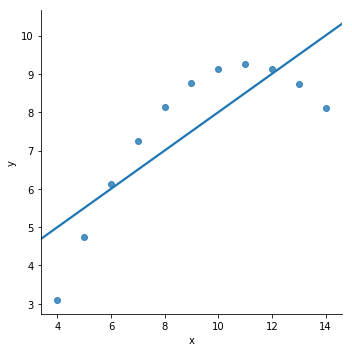

In [18]:
ols_X2 = df2.x
ols_y2 = df2.y 
ols_X2 = sm.add_constant(ols_X2)

model_2 = sm.OLS(ols_y2, ols_X2).fit()
predictions = model_2.predict(ols_X2)

lmplot = sb.lmplot("x", "y", data=df2, ci = None)

In [10]:
model_2.summary()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.97
Date:                Fri, 15 Feb 2019   Prob (F-statistic):            0.00218
Time:                        19:44:07   Log-Likelihood:                -16.846
No. Observations:                  11   AIC:                             37.69
Df Residuals:                       9   BIC:                             38.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0009      1.125      2.667      0.026       0.455       5.547
x              0.5000      0.118      4.239      0.002       0.233       0.767
==============================================================================
Omnibus:                        1.594   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.451   Jarque-Bera (JB):                1.108
Skew:                          -0.567   Prob(JB):                        0.575
Kurtosis:                       1.936   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

\begin{align}
R^2 & = 0.666 \\
R_a^2 & = 0.629 \\
P & > |t| = 0.02
\end{align}


1) Looking at the scatter plot, we know immediately that the fitted line is not good, since the points resemble a parabolic line whereas the fitted line is a straight line. This results in the error plot to follow a parabolic shape. To remedy this, we can increase the order of the function to 2.

2) The (P > |t|) value is 0.02, which is statistically significant and we can reject the null (reject that $H_0 = 0$) and there is some correlation. 

3) Similar to the first plot from the first set, the difference is quite big with $R^2 =.666$ and $R_a^2 =0.629$. This is because $R_a^2$ is scaled on # of data points and number of predictors. The difference can therefore be explained by the extremely small dataset of n=10 that was used in this example.

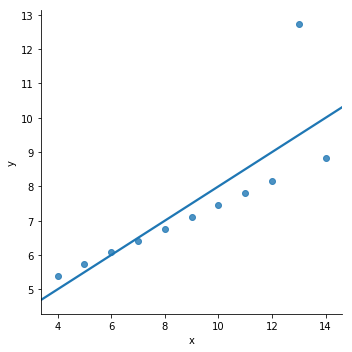

In [19]:
ols_X3 = df3.x
ols_y3 = df3.y 
ols_X3 = sm.add_constant(ols_X3)

model_3 = sm.OLS(ols_y3, ols_X3).fit()
predictions = model_3.predict(ols_X3)

lmplot = sb.lmplot("x", "y", data=df3, ci = None)

In [14]:
model_3.summary()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.97
Date:                Fri, 15 Feb 2019   Prob (F-statistic):            0.00218
Time:                        19:48:48   Log-Likelihood:                -16.838
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0025      1.124      2.670      0.026       0.459       5.546
x              0.4997      0.118      4.239      0.002       0.233       0.766
==============================================================================
Omnibus:                       19.540   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.478
Skew:                           2.041   Prob(JB):                      0.00118
Kurtosis:                       6.571   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

\begin{align}
R^2 & = 0.666 \\
R_a^2 & = 0.629 \\
P & > |t| = 0.02
\end{align}


1) Looking at the scatter plot, we know can see that one outlying point is significantly affecting otherwise a perfect fit to the points. Furthermore, it seems like the fitted line may have a problem of heteroskedasticity, where the error is not constant.

2) The (P > |t|) value is 0.02, which is statistically significant and we can reject the null (reject that $H_0 = 0$) and there is some correlation. 

3) Similar to the first plot from the first set, the difference is quite big with $R^2 =.666$ and $R_a^2 =0.629$. This is because $R_a^2$ is scaled on # of data points and number of predictors. The difference can therefore be explained by the extremely small dataset of n=10 that was used in this example.

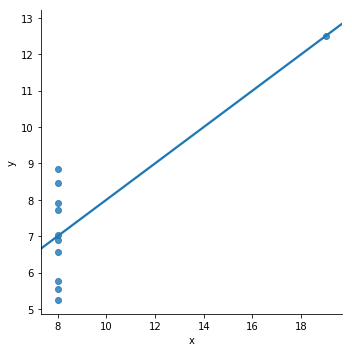

In [20]:
ols_X4 = df4.x
ols_y4 = df4.y 
ols_X4 = sm.add_constant(ols_X4)

model_4 = sm.OLS(ols_y4, ols_X4).fit()
predictions = model_4.predict(ols_X4)

lmplot = sb.lmplot("x", "y", data=df4, ci = None)

In [13]:
model_4.summary()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     18.00
Date:                Fri, 15 Feb 2019   Prob (F-statistic):            0.00216
Time:                        19:48:38   Log-Likelihood:                -16.833
No. Observations:                  11   AIC:                             37.67
Df Residuals:                       9   BIC:                             38.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0017      1.124      2.671      0.026       0.459       5.544
x              0.4999      0.118      4.243      0.002       0.233       0.766
==============================================================================
Omnibus:                        0.555   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.524
Skew:                           0.010   Prob(JB):                        0.769
Kurtosis:                       1.931   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1) Looking at the data and the plot, we can see a significant problem where there are multiple y-values for a single x-value

2) The P>|t| value is 0.002 meaning we can reject the null hypothesis.

3) $R^2 = 0.667$ and $R_a^2 = 0.630$. Similar to before, this discrepancy is due to the limited number of sampled data.